## Phase-2 max cluster

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append('../')

In [3]:
## Load data
from notebooklib.save import load_tsdr

DATASET_ID = "qknmc"  # sockshop
datasets = load_tsdr(DATASET_ID, revert_normalized_time_series=True)
assert len(datasets) != 0

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
from tsdr import tsdr
from meltria.priorknowledge import priorknowledge

from joblib import Parallel, delayed


pk = priorknowledge.new_knowledge(
    target_app="sock-shop",
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewalres": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

def _hdbscan_clustering(pk, data_df: pd.DataFrame, dist_type="sbd"):
    data_df = data_df.apply(scipy.stats.zscore)
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 2,
        "step2_dbscan_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "hdbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df, pk, n_workers=1)
    return clustering_info

def _fluxrank_clustering(pk, data_df: pd.DataFrame, dist_type="pearsonr", choice_method="medoid"):
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": choice_method,  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df, pk, n_workers=1)
    return clustering_info

In [5]:
clustering_infos = Parallel(n_jobs=-1)(delayed(_hdbscan_clustering)(pk, ts, dist_type="pearsonr") for ts in [datasets[0][2]])

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
clustering_infos_fluxrank = Parallel(n_jobs=-1)(delayed(_fluxrank_clustering)(pk, ts, dist_type="pearsonr") for ts in [datasets[0][2]])

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    vdf = pd.DataFrame([(i, k, len(v)) for i, cinfo in enumerate(clustering_infos) for k, v in cinfo.items()], columns=["dataset", "cluster", "size"])
    display(vdf)

dataset                                            cluster  size
0          0                                  c-carts_processes     7
1          0                     c-carts_cpu_user_seconds_total     3
2          0  m-carts_Tomcat_GlobalRequestProcessor_requestC...    28
3          0  m-carts_java_lang_OperatingSystem_FreePhysical...     2
4          0     m-carts_Tomcat_RequestProcessor_processingTime     3
5          0      m-carts_java_lang_Threading_DaemonThreadCount     2
6          0                   m-carts_java_lang_Runtime_Uptime     3
7          0              m-carts_Tomcat_WebModule_requestCount     2
8          0         m-carts_Tomcat_WebResourceRoot_lookupCount     2
9          0                                 c-carts-db_threads     2
10         0      m-carts-db_mongodb_ss_extra_info_input_blocks    10
11         0  m-carts-db_mongodb_ss_wt_log_slot_join_calls_d...   130
12         0                      c-carts-db_memory_usage_bytes     7
13         0         c-carts-db_cpu_cfs_throttled_seconds_total     4
14         0  m-carts-db_mongodb_ss_wt_lock_dhandle_write_lo...     7
15         0         m-carts-db_mongodb_ss_wt_log_slot_closures     6
16         0  m-carts-db_mongodb_ss_locks_Global_acquireCount_r     7
17         0  m-carts-db_mongodb_ss_wt_txn_transaction_check...     3
18         0  m-carts-db_mongodb_ss_wt_reconciliation_approx...     3
19         0   m-carts-db_mongodb_sys_mounts_data_configdb_free    14
20         0  m-carts-db_mongodb_ss_wt_cache_pages_written_r...     9
21         0     m-carts-db_mongodb_ss_wt_log_log_bytes_written    15
22         0               m-carts-db_mongodb_dbstats_totalSize     4
23         0  m-carts-db_mongodb_ss_network_serviceExecutors...     1
24         0  m-carts-db_mongodb_sys_netstat_TcpExt_TCPOrigD...     7
25         0  m-carts-db_mongodb_ss_tcmalloc_tcmalloc_pagehe...     1
26         0  m-carts-db_mongodb_ss_wt_log_log_sync_dir_time...     3
27         0  m-carts-db_mongodb_sys_netstat_TcpExt_TCPDSACK...     5
28         0                 m-carts-db_mongodb_sys_cpu_idle_ms     1
29         0                 m-carts-db_mongodb_ss_uptimeMillis     6
30         0                             m-carts-db_mongodb_end     1
31         0  m-carts-db_mongodb_ss_wt_cache_pages_selected_...     3
32         0              m-carts-db_mongodb_ss_network_bytesIn     5
33         0             m-carts-db_mongodb_ss_network_bytesOut     2
34         0  m-carts-db_mongodb_ss_wt_cache_eviction_walks_...     6
35         0  m-carts-db_mongodb_ss_wt_cache_tracked_dirty_b...     2
36         0                m-carts-db_mongodb_dbstats_dataSize     4
37         0  m-carts-db_mongodb_ss_wt_block_manager_bytes_w...     5
38         0  m-carts-db_mongodb_ss_wt_cache_pages_queued_fo...     3
39         0       m-carts-db_mongodb_sys_netstat_Ip_InReceives     3
40         0   m-carts-db_mongodb_ss_tcmalloc_generic_heap_size     6
41         0  m-carts-db_mongodb_ss_wt_txn_transaction_check...     2
42         0  m-carts-db_mongodb_ss_locks_Collection_acquire...     5
43         0  m-carts-db_mongodb_ss_wt_log_slot_join_calls_a...     3
44         0  m-carts-db_mongodb_ss_wt_cursor_cursor_close_c...     2
45         0  m-carts-db_mongodb_ss_wt_cursor_open_cursor_count     2
46         0  m-carts-db_mongodb_ss_wt_cache_bytes_not_belon...     6
47         0  m-carts-db_mongodb_ss_wt_cursor_cursor_next_calls     2
48         0  m-carts-db_mongodb_ss_wt_cache_in_memory_page_...     1
49         0  m-carts-db_mongodb_ss_wt_cache_eviction_walk_t...     3
50         0       m-carts-db_mongodb_sys_netstat_Tcp_CurrEstab     5
51         0  m-carts-db_mongodb_ss_wt_connection_pthread_mu...     2
52         0  m-carts-db_mongodb_ss_wt_lock_txn_global_write...     2
53         0  m-carts-db_mongodb_ss_wt_connection_auto_adjus...     2
54         0  m-carts-db_mongodb_sys_netstat_TcpExt_TCPSACKR...     2
55         0                   c-payment_memory_max_usage_bytes     7
56         0   

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesS

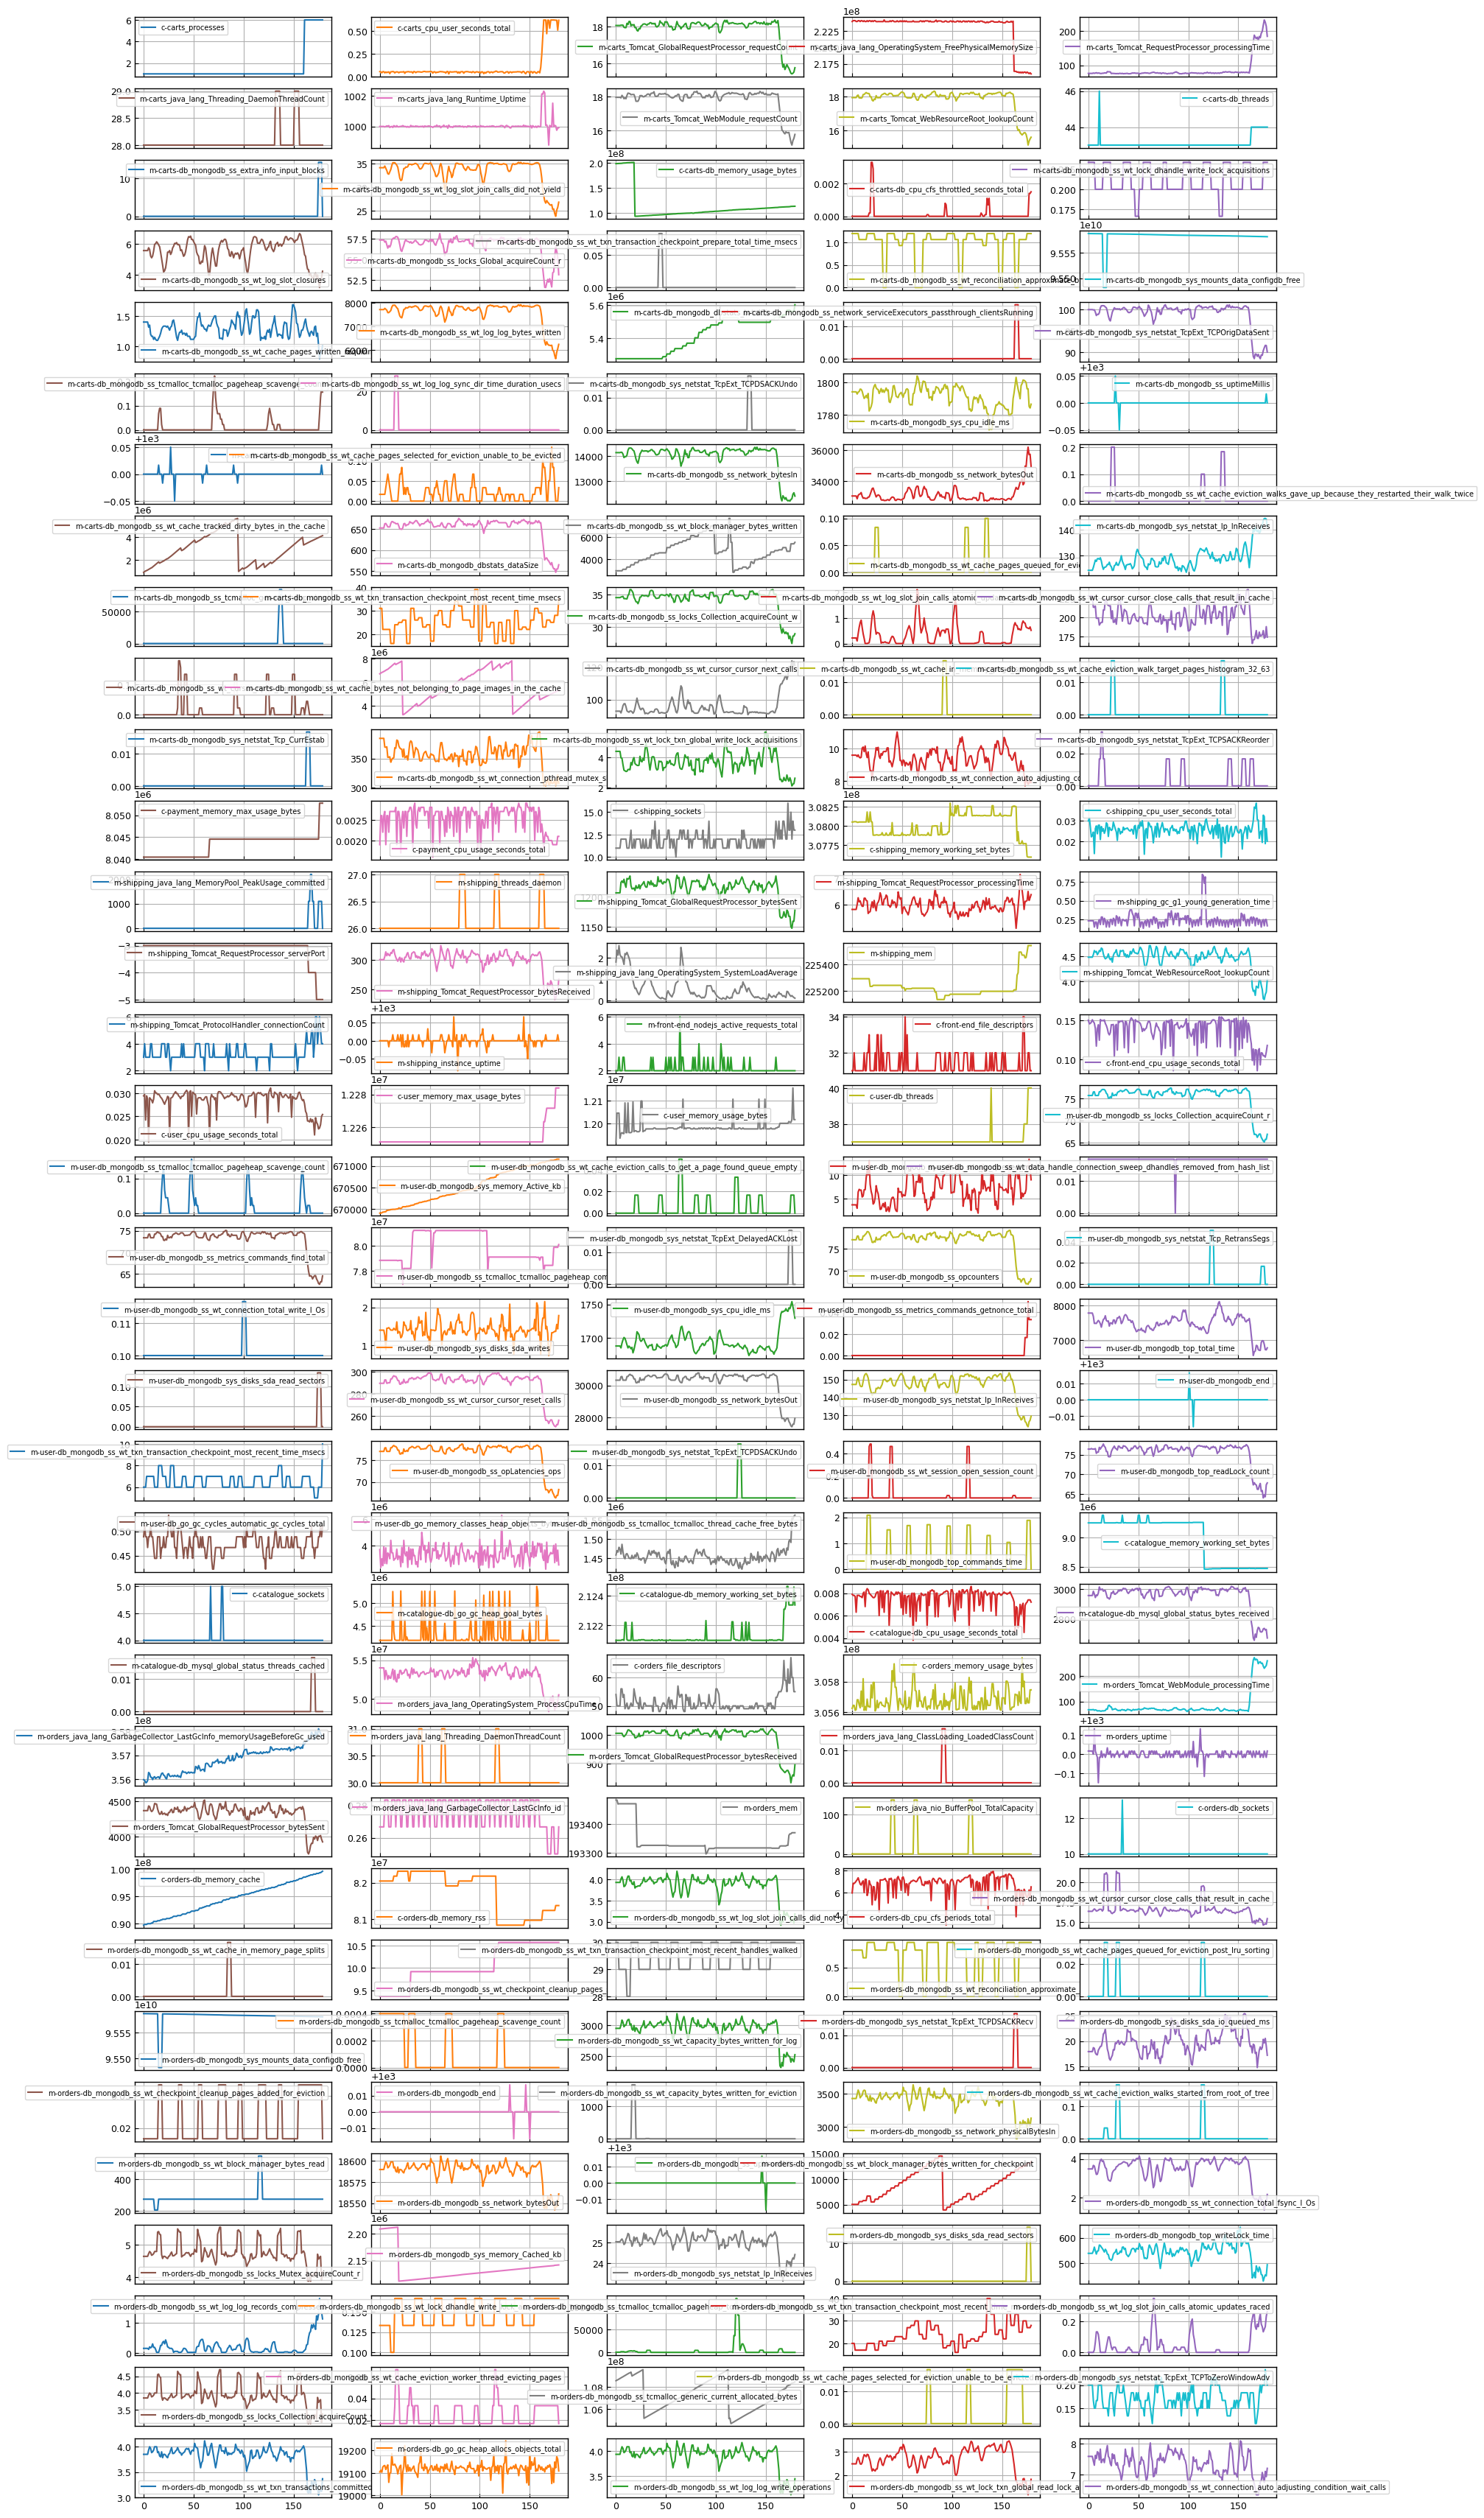

In [8]:
import math

datasets[0][2][[k for i, cinfo in enumerate(clustering_infos) for k, v in cinfo.items()]].plot(figsize=(20, 50), layout=(math.ceil(196/5), 5), subplots=True, legend=True, sharex=True, sharey=False)

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    vdf = pd.DataFrame([(i, k, len(v)) for i, cinfo in enumerate(clustering_infos_fluxrank) for k, v in cinfo.items()], columns=["dataset", "cluster", "size"])
    display(vdf)

dataset                                            cluster  size
0          0            c-carts_cpu_cfs_throttled_periods_total    32
1          0                      c-carts_memory_failures_total     0
2          0           m-carts_Tomcat_ThreadPool_keepAliveCount     0
3          0      m-carts_java_lang_Threading_DaemonThreadCount     2
4          0   m-carts_java_lang_OperatingSystem_ProcessCpuLoad     0
5          0            m-carts_Tomcat_RequestProcessor_maxTime     0
6          0              m-carts_Tomcat_Servlet_countAllocated     0
7          0  m-carts_Tomcat_RequestProcessor_requestBytesRe...     0
8          0  m-carts_java_lang_GarbageCollector_LastGcInfo_...     0
9          0     m-carts_org_mongodb_driver_ConnectionPool_Size     0
10         0  m-carts_org_mongodb_driver_ConnectionPool_Chec...     0
11         0                   m-carts_java_lang_Runtime_Uptime     0
12         0      m-carts_Tomcat_RequestProcessor_contentLength     0
13         0    m-carts_Tomcat_GlobalRequestProcessor_bytesSent     0
14         0  m-carts_java_lang_Compilation_TotalCompilation...     0
15         0  m-carts_java_lang_GarbageCollector_CollectionC...     1
16         0  m-carts_java_lang_GarbageCollector_LastGcInfo_...     0
17         0          m-carts_Tomcat_RequestProcessor_bytesSent     0
18         0  m-carts_java_lang_OperatingSystem_SystemLoadAv...     0
19         0   m-carts_java_lang_Memory_NonHeapMemoryUsage_used     0
20         0              m-carts_Tomcat_Manager_processingTime     0
21         0        m-carts_java_lang_MemoryPool_PeakUsage_used     0
22         0       m-carts_Tomcat_ThreadPool_currentThreadsBusy     0
23         0     m-carts_Tomcat_ProtocolHandler_connectionCount     1
24         0  m-carts_Tomcat_RequestProcessor_requestProcess...     0
25         0                                 c-carts-db_sockets     2
26         0  m-carts-db_mongodb_ss_metrics_commands_insert_...   123
27         0                 c-carts-db_cpu_usage_seconds_total     3
28         0                      c-carts-db_memory_usage_bytes     7
29         0         c-carts-db_cpu_cfs_throttled_seconds_total     1
30         0                              c-carts-db_memory_rss     0
31         0                   c-carts-db_memory_failures_total     0
32         0  m-carts-db_mongodb_ss_wt_data_handle_connectio...     0
33         0              m-carts-db_mongodb_dbstats_avgObjSize     0
34         0  m-carts-db_mongodb_ss_wt_checkpoint_cleanup_pa...    10
35         0  m-carts-db_mongodb_ss_wt_cache_eviction_calls_...     1
36         0  m-carts-db_mongodb_ss_wt_txn_transaction_check...     2
37         0  m-carts-db_mongodb_ss_wt_data_handle_session_d...     0
38         0     m-carts-db_mongodb_sys_netstat_Tcp_RetransSegs     5
39         0  m-carts-db_mongodb_ss_wt_reconciliation_approx...     3
40         0              m-carts-db_mongodb_dbstats_fsUsedSize    18
41         0  m-carts-db_mongodb_ss_indexStats_features_id_a...     2
42         0  m-carts-db_mongodb_ss_wt_cache_forced_eviction...     0
43         0  m-carts-db_mongodb_sys_netstat_TcpExt_DelayedACKs     0
44         0  m-carts-db_mongodb_ss_wt_cache_pages_written_r...     8
45         0     m-carts-db_mongodb_ss_extra_info_page_reclaims     0
46         0  m-carts-db_mongodb_ss_network_serviceExecutors...     8
47         0  m-carts-db_mongodb_ss_wt_txn_transaction_check...     4
48         0  m-carts-db_mongodb_ss_wt_cache_eviction_walks_...    18
49         0  m-carts-db_mongodb_ss_extra_info_maximum_resid...     0
50         0  m-carts-db_mongodb_ss_tcmalloc_tcmalloc_pagehe...     1
51         0  m-carts-db_mongodb_ss_wt_checkpoint_cleanup_pa...     0
52         0  m-carts-db_mongodb_ss_wt_thread_yield_page_acq...     0
53         0  m-carts-db_mongodb_ss_wt_data_handle_session_s...     0
54         0     m-carts-db_mongodb_sys_disks_sda_write_time_ms     1
55         0                 m-carts-db_mongodb_ss_uptimeMillis     8
56         0  m

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesS

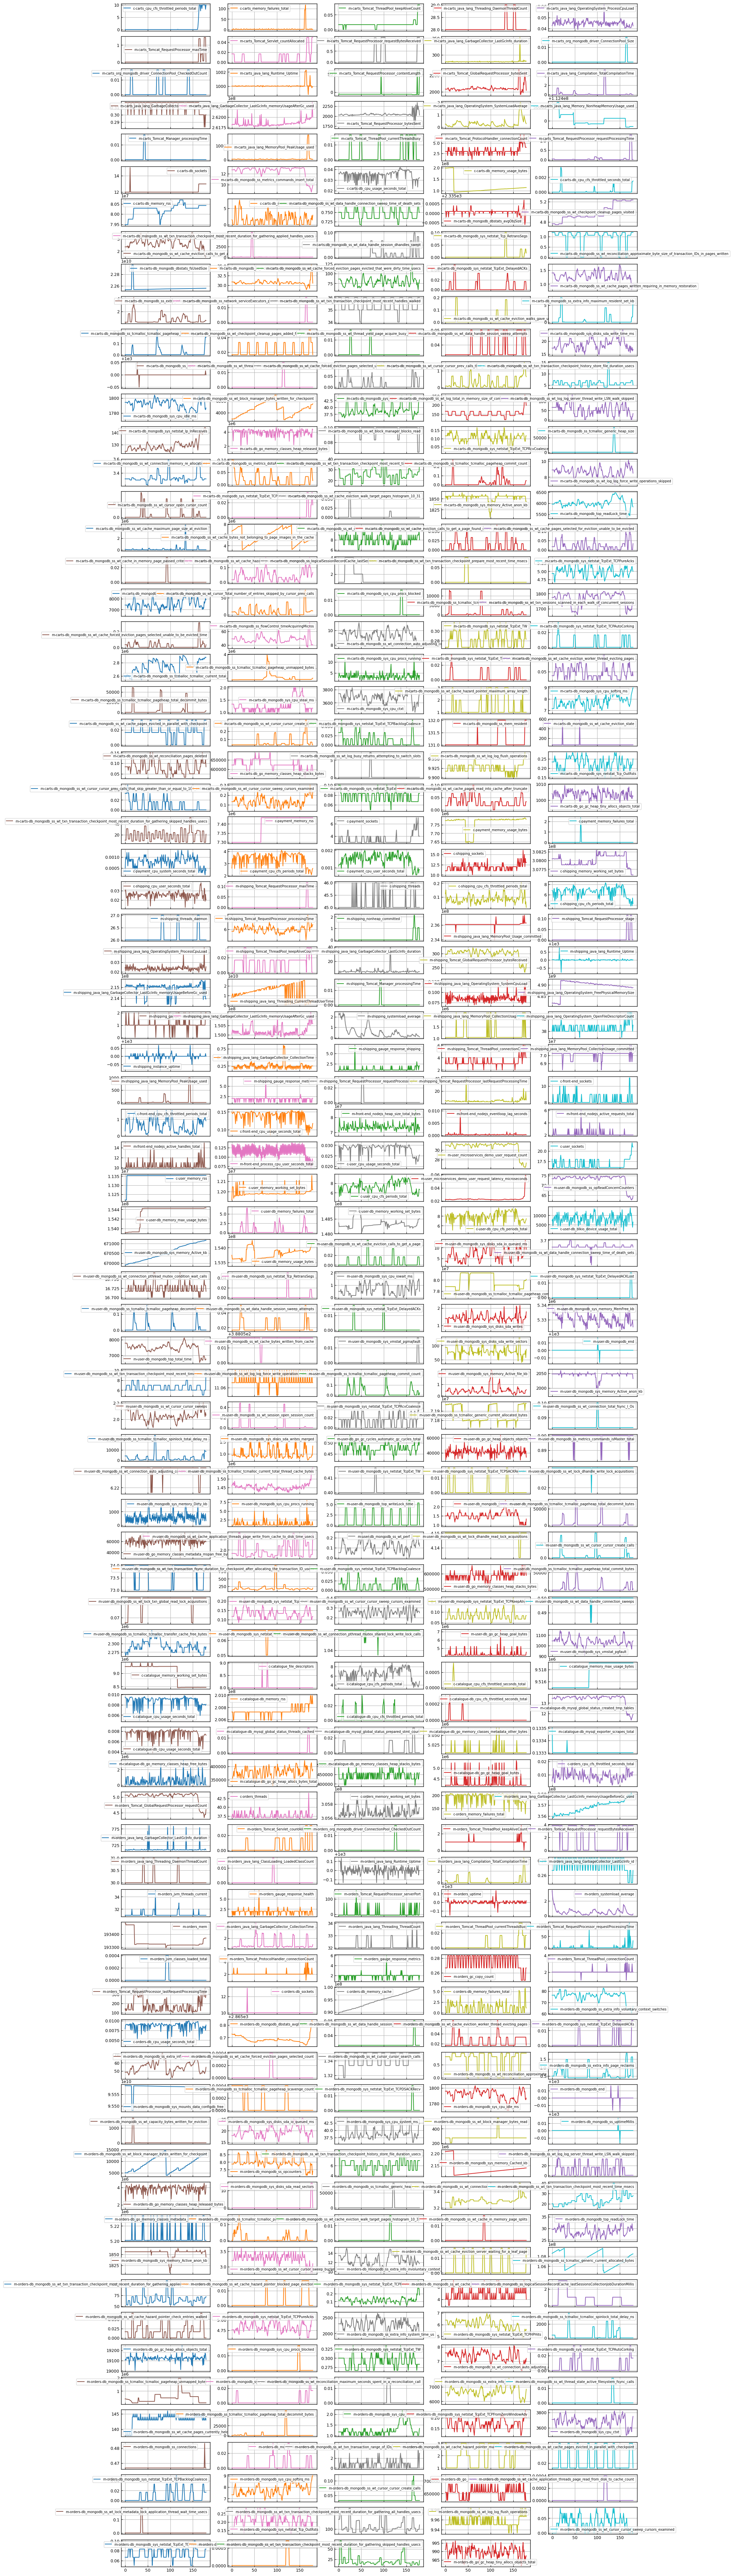

In [10]:
rep_metrics_fluxrank = [k for i, cinfo in enumerate(clustering_infos_fluxrank) for k, v in cinfo.items()]
datasets[0][2][rep_metrics_fluxrank].plot(
    figsize=(20, 100), layout=(math.ceil(len(rep_metrics_fluxrank)/5), 5), subplots=True, legend=True, sharex=True, sharey=False,
)

In [11]:
clustering_infos_fluxrank_max_cluster = Parallel(n_jobs=-1)(delayed(_fluxrank_clustering)(pk, ts, dist_type="pearsonr", choice_method="max_cluster") for ts in [datasets[0][2]])

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


rep_metrics_fluxrank = [k for i, cinfo in enumerate(clustering_infos_fluxrank_max_cluster) for k, v in cinfo.items()]
datasets[0][2][rep_metrics_fluxrank].plot(
    figsize=(20, 100), layout=(math.ceil(len(rep_metrics_fluxrank)/5), 5), subplots=True, legend=True, sharex=True, sharey=False,
)